In [86]:
import pandas as pd
from pandas import option_context
import numpy as np

import nltk
from nltk.corpus import stopwords

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('04-data/training_base.csv')

In [3]:
df.shape

(3576, 10)

In [4]:
def remove_space(text):
    text = text.strip()
    text = re.sub("\s\s+", " ", text)
    return text
    
df['tweet_compound'] = df.tweet_compound.map(remove_space)
df['tweet'] = df.tweet.map(remove_space)

In [5]:
df.to_csv('04-data/training_base_new.csv')

In [6]:
df1 = pd.read_csv('04-data/training_base_new.csv')

In [7]:
train, test = train_test_split(df1, test_size = 0.2, random_state=10)

In [8]:
train.groupby('intent').count()

,Unnamed: 0,Unnamed: 0.1,username,tweet,tweet_compound,topic,neg,neu,pos,compound
intent,,,,,,,,,,
0,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111
2,1280,1280,1280,1280,1280,1280,1280,1280,1280,1280
3,182,182,182,182,182,182,182,182,182,182
4,287,287,287,287,287,287,287,287,287,287


In [9]:
stop = stopwords.words('english')

# Intent analysis

## With XGBoost
### No tuning

In [22]:
X_tr3 = train['tweet']
y_tr3 = train[['intent']]

In [23]:
# creating bag of words model 
cv3 = CountVectorizer(stop_words = stop,
                      max_features=880) 
  
X3 = cv3.fit_transform(train['tweet']).toarray() 
y3 = y_tr3.iloc[:, 0].values 

# fitting XGB to the training set 
gbm3 = xgb.XGBClassifier(max_depth=5,
                         learning_rate = 0.05,
                         objective = 'multi:softmax',
                         num_class = 4)

In [24]:
gbm3.fit(X3,y3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
test_gbm3 = test.copy()
X_test3 = test['tweet']
X_t3_cv = cv3.fit_transform(X_test3).toarray() 
y_pred3 = gbm3.predict(X_t3_cv)
gbm_pred3 = [round(value) for value in y_pred3]
test_gbm3['pred'] =  gbm_pred3

In [26]:
accuracy3 = accuracy_score(test['intent'], gbm_pred3)
print("Accuracy: %.2f%%" % (accuracy3 * 100.0))

Accuracy: 49.02%


In [27]:
confusion_matrix(test['intent'], test_gbm3['pred'])

array([[ 91, 150,   5,  18],
       [ 69, 257,   3,  12],
       [ 11,  31,   2,   1],
       [  8,  57,   0,   1]])

In [28]:
print(classification_report(test['intent'], test_gbm3['pred']))

              precision    recall  f1-score   support

           0       0.51      0.34      0.41       264
           2       0.52      0.75      0.61       341
           3       0.20      0.04      0.07        45
           4       0.03      0.02      0.02        66

    accuracy                           0.49       716
   macro avg       0.31      0.29      0.28       716
weighted avg       0.45      0.49      0.45       716



In [29]:
test_gbm3.groupby('pred').count()

,Unnamed: 0,Unnamed: 0.1,username,tweet,tweet_compound,intent,topic,neg,neu,pos,compound
pred,,,,,,,,,,,
0,179,179,179,179,179,179,179,179,179,179,179
2,495,495,495,495,495,495,495,495,495,495,495
3,10,10,10,10,10,10,10,10,10,10,10
4,32,32,32,32,32,32,32,32,32,32,32


## Tuned parameters

In [30]:
X_tr4 = train['tweet']
y_tr4 = train[['intent']]

In [31]:
# creating bag of words model 
cv4 = CountVectorizer(stop_words = stop,
                      max_features=880) 
  
X4 = cv4.fit_transform(X_tr4).toarray() 
y4 = y_tr4.iloc[:, 0].values 

# fitting XGB to the training set 
gbm4 = xgb.XGBClassifier(max_depth = 7,
                         learning_rate = 0.05,
                         subsample= 0.9,
                         colsample_bytree = 0.8,
                         objective= 'multi:softmax',
                         num_class = 4)

In [32]:
gbm4.fit(X4,y4)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
test_gbm4 = test.copy()
X_test4 = test_gbm4['tweet']
X_t4_cv = cv4.fit_transform(X_test4).toarray() 
y_pred4 = gbm4.predict(X_t4_cv)
gbm_pred4 = [round(value) for value in y_pred4]
test_gbm4['pred'] =  gbm_pred4

In [34]:
accuracy4 = accuracy_score(test['intent'], gbm_pred4)
print("Accuracy: %.2f%%" % (accuracy4 * 100.0))

Accuracy: 50.00%


In [76]:
conf = confusion_matrix(test['intent'], test_gbm4['pred'])
conf

array([[106, 132,   5,  21],
       [ 67, 248,   4,  22],
       [ 10,  29,   3,   3],
       [ 13,  52,   0,   1]])

Strong results given the number of labels

In [63]:
cl_names = ['Complaint', 'Query', 'Compliment', 'Other']

In [36]:
print(classification_report(test['intent'], test_gbm4['pred']))

              precision    recall  f1-score   support

           0       0.54      0.40      0.46       264
           2       0.54      0.73      0.62       341
           3       0.25      0.07      0.11        45
           4       0.02      0.02      0.02        66

    accuracy                           0.50       716
   macro avg       0.34      0.30      0.30       716
weighted avg       0.47      0.50      0.47       716



In [84]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,8), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt=".1%",cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig("cm_xgb.svg")
    return fig


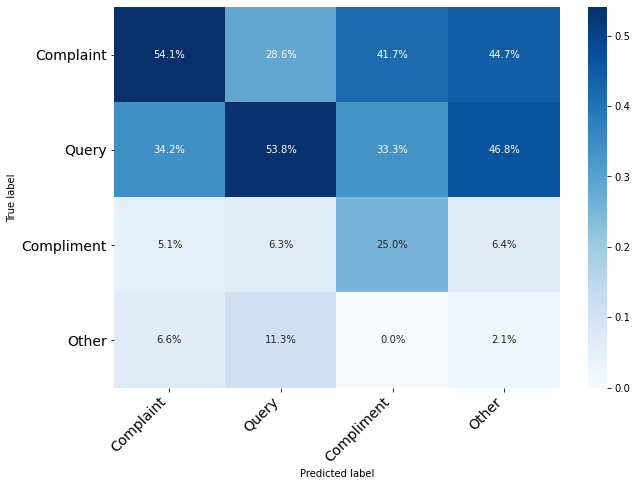

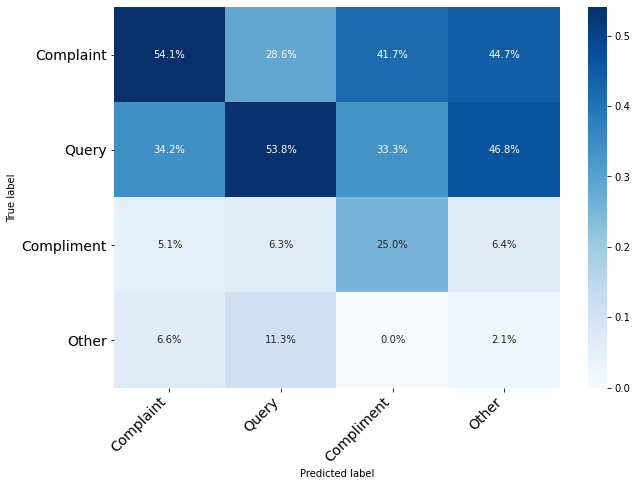

In [87]:
print_confusion_matrix(conf, cl_names)

In [37]:
import pickle
# save the model
filename1 = 'intentxgb_model.sav'
pickle.dump(gbm4, open(filename1, 'wb'))

### XGB with ROS

In [38]:
## RF with Oversampling
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [39]:
# define resampling
strategyo = {3:500, 4:500}
strategyu = {0:500, 2:500}
over = RandomOverSampler(sampling_strategy=strategyo)
under = RandomUnderSampler(sampling_strategy=strategyu)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [40]:
# fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(train[['tweet']], train['intent'])

In [41]:
y_resampled.value_counts()

4    500
3    500
2    500
0    500
Name: intent, dtype: int64

In [42]:
X_resampled_ser = X_resampled['tweet']

In [43]:
# creating bag of words model 
cv6 = CountVectorizer(stop_words = stop,
                      max_features=880) 
  
X6 = cv6.fit_transform(X_resampled_ser).toarray() 
y6 = y_resampled.to_numpy()

In [44]:
# fitting XGB to the training set 
gbm6 = xgb.XGBClassifier(max_depth = 7,
                         learning_rate = 0.05,
                         subsample= 0.9,
                         colsample_bytree = 0.8,
                         objective= 'multi:softmax',
                         num_class = 4)

gbm6.fit(X6,y6)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
test_gbm6 = test.copy()
X_test6 = test_gbm4['tweet']
X_t6_cv = cv6.fit_transform(X_test6).toarray() 
y_pred6 = gbm6.predict(X_t6_cv)
gbm_pred6 = [round(value) for value in y_pred6]
test_gbm6['pred'] =  gbm_pred6

In [46]:
accuracy6 = accuracy_score(test['intent'], gbm_pred6)
print("Accuracy: %.2f%%" % (accuracy6 * 100.0))

Accuracy: 15.08%


In [47]:
confusion_matrix(test['intent'], test_gbm6['pred'])

array([[ 41,  11,  24, 188],
       [ 24,  10,  22, 285],
       [  2,   0,   3,  40],
       [  2,   3,   7,  54]])

In [48]:
print(classification_report(test['intent'], test_gbm6['pred']))

              precision    recall  f1-score   support

           0       0.59      0.16      0.25       264
           2       0.42      0.03      0.05       341
           3       0.05      0.07      0.06        45
           4       0.10      0.82      0.17        66

    accuracy                           0.15       716
   macro avg       0.29      0.27      0.13       716
weighted avg       0.43      0.15      0.14       716



Balancing classes improved prediction of the Other class but negatively effected prediction on the other 3 classes

## Random forest

In [49]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X4,y4)

X_test4_rf = cv4.fit_transform(test['tweet']).toarray() 
y_pred4_rf = clf.predict(X_test4_rf)

In [50]:
print("Accuracy:",accuracy_score(test['intent'], y_pred4_rf))

Accuracy: 0.4175977653631285


In [51]:
confusion_matrix(test['intent'], y_pred4_rf)

array([[122,  84,  15,  43],
       [123, 151,  10,  57],
       [ 18,  16,   6,   5],
       [ 13,  29,   4,  20]])

In [52]:
print(classification_report(test['intent'], y_pred4_rf))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45       264
           2       0.54      0.44      0.49       341
           3       0.17      0.13      0.15        45
           4       0.16      0.30      0.21        66

    accuracy                           0.42       716
   macro avg       0.33      0.34      0.32       716
weighted avg       0.45      0.42      0.43       716



Better than previous models in terms of predicting class 3, which is important. However, worse performance overall

In [53]:
## RF with Oversampling
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(train[['tweet']], train['intent'])

from collections import Counter
# Yay, balanced classes!
Counter(y_resampled)

Counter({0: 1280, 2: 1280, 3: 1280, 4: 1280})

In [54]:
X_resampled_ser = X_resampled['tweet']

In [56]:
# creating bag of words model 
cv6 = CountVectorizer(stop_words = stop,
                      max_features=880) 
  
X6 = cv6.fit_transform(X_resampled_ser).toarray() 
y6 = y_resampled.to_numpy()

In [57]:
#Create a Gaussian Classifier
clf6 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf6.fit(X6,y6)

X_test6_rf = cv6.fit_transform(test['tweet']).toarray() 
y_pred6_rf = clf6.predict(X_test6_rf)

In [58]:
print("Accuracy:",accuracy_score(test['intent'], y_pred6_rf))

Accuracy: 0.30027932960893855


In [59]:
confusion_matrix(test['intent'], y_pred6_rf)

array([[ 99,  56,  40,  69],
       [114,  87,  68,  72],
       [ 13,  17,   7,   8],
       [ 15,  17,  12,  22]])

In [60]:
print(classification_report(test['intent'], y_pred6_rf))

              precision    recall  f1-score   support

           0       0.41      0.38      0.39       264
           2       0.49      0.26      0.34       341
           3       0.06      0.16      0.08        45
           4       0.13      0.33      0.19        66

    accuracy                           0.30       716
   macro avg       0.27      0.28      0.25       716
weighted avg       0.40      0.30      0.33       716

